Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
          Date         Open         High  ...       EMA 12       EMA 26       MACD
0   2000-01-03  6762.109863  6762.109863  ...  6762.109863  6762.109863   0.000000
1   2000-01-04  6543.759766  6543.759766  ...  6643.836894  6648.735774  -4.898880
2   2000-01-05  6567.029785  6567.029785  ...  6613.859061  6619.379606  -5.520544
3   2000-01-06  6635.439941  6635.439941  ...  6620.671302  6623.869374  -3.198072
4   2000-01-07  6792.669922  6792.669922  ...  6667.402712  6663.014917   4.387795
5   2000-01-10  6838.450195  6838.450195  ...  6708.976249  6698.153204  10.823045
6   2000-01-11  6774.479980  6774.479980  ...  6723.593178  6711.727525  11.865652
7   2000-01-12  6766.549805  6766.549805  ...  6732.557564  6720.560753  11.996811
8   2000-01-13  6836.759766  6836.759766  ...  6753.172468  6737.783998  15.388470
9   2000-01-14  6870.490234  6870.490234 

Text(0, 0.5, 'USD')

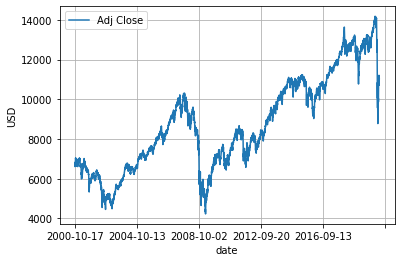

In [69]:
import tensorflow as tf
import pandas as pd
import numpy as np
import math
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale
from google.colab import drive
drive.mount('/content/drive')
# Quick disclaimer. I don't recommend you run this code locally as it will
# Take a lot of your computational resources and time to train. 
# If you would like to run this code, please run it on Google Colab with a GPU
  # Edit -> Notebook Settings -> GPU
# The purpose of this code is to show what I have done to train a model that makes stock market predictions
url = '/content/drive/My Drive/COMP3900 Data/^NYA.csv'
dataset = pd.read_csv(url)

# Creating additional techincal analysis features to help predictions
# MA is moving average over x number of previous days
# EMA is exponential moving average over x number of previous days
# MACD is moving average convergence divergence
def get_technical_analysis(dataset):
  dataset['MA 7'] = dataset['Close'].rolling(window=7).mean()
  dataset['MA 20'] = dataset['Close'].rolling(window=20).mean()
  dataset['MA 50'] = dataset['Close'].rolling(window=50).mean()
  dataset['MA 200'] = dataset['Close'].rolling(window=200).mean()
  dataset['EMA 20'] = dataset['Close'].ewm(span=20).mean()
  dataset['EMA 50'] = dataset['Close'].ewm(span=50).mean()
  dataset['EMA 200'] = dataset['Close'].ewm(span=200).mean()
  dataset['EMA 12'] = dataset['Close'].ewm(span=12).mean()
  dataset['EMA 26'] = dataset['Close'].ewm(span=26).mean()
  dataset['MACD'] = dataset['EMA 12'] - dataset['EMA 26']

get_technical_analysis(dataset)
print(dataset.head(20))
include = ['Date', 'Adj Close', 'Volume', 
           'MA 7', 'MA 20', 'MA 50', 'MA 200', 
           'EMA 12', 'EMA 20', 'EMA 26', 'EMA 50', 'EMA 200', 'MACD']
features = ['Adj Close', 'Volume', 'MA 7', 'MA 20', 'MA 50', 'MA 200', 
           'EMA 12', 'EMA 20', 'EMA 26', 'EMA 50', 'EMA 200', 'MACD']
print(dataset.shape)
dataset = dataset[200:]
print(dataset.shape)
# Splitting the data into different parts for model training and testing
train_cut = math.ceil(dataset.shape[0] * 0.6)
train = dataset[:train_cut][include]
val_cut = math.ceil(dataset.shape[0] * 0.8)
val = dataset[train_cut:val_cut][include]
test = dataset[val_cut:][include]
ax = dataset.plot(x='Date', y='Adj Close', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [0]:
# This function is to split data into 
# x values (input values to make predictions),and y values (correct output)
def get_xy(data, lags, num_predictions):
  x = []
  y = []
  for i in range(lags, len(data) - num_predictions):
    x.append(np.array(data[i-lags:i]))
    y.append(np.array(data[i:i+num_predictions]))
  x = np.array(x)
  y = np.array(y)[:,:,0]
  y = y.reshape(y.shape + (1,))
  return x, y

# Function for testing accuracy. MAPE (Mean absolute percentage error) is 
# a really common way to measure accuracy, where the lower the MAPE value, the better
def get_mape(y_true, y_pred): 
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [71]:
# Preprocessing for the training set
print(train.head(5))
train_adj=train[features]
forecasts = 10
lags = 100
feature_sets = len(features)
# Feature scaling all features
scalers = [MinMaxScaler() for a in range(len(features))]
print(train_adj.head(5))
for a, feature in zip(range(len(features)), features):
  train_adj.loc[:, feature] = scalers[a].fit_transform(np.array(train[feature]).reshape(-1,1))
print(train_adj.head(5))
print(train_adj.shape)
train_x, train_y = get_xy(train_adj, lags, forecasts)
print(train_x.shape)
print(train_y.shape)
# Actual model. 
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=250,input_shape=(lags,feature_sets),return_sequences=True))
model.add(layers.Dropout(0.25))
model.add(tf.keras.layers.LSTM(units=100,return_sequences=True))
model.add(tf.keras.layers.LSTM(units=100))
model.add(tf.keras.layers.Dense(128,activation='tanh'))
model.add(tf.keras.layers.Dense(128,activation='tanh'))
model.add(tf.keras.layers.Dense(64,activation='tanh'))
model.add(tf.keras.layers.Dense(64,activation='tanh'))
model.add(layers.Dense(forecasts))
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])
history=model.fit(train_x.reshape(train_x.shape[0], train_x.shape[1], -1), train_y.reshape(train_y.shape[0], -1), epochs=80, verbose=2)
model.summary()

           Date    Adj Close  Volume  ...       EMA 50      EMA 200       MACD
200  2000-10-17  6655.740234       0  ...  6950.908601  6884.456023 -86.114499
201  2000-10-18  6609.740234       0  ...  6937.525309  6881.304469 -96.922924
202  2000-10-19  6753.020020       0  ...  6930.287656  6879.835019 -92.856804
203  2000-10-20  6790.129883       0  ...  6924.789703  6878.809024 -85.652569
204  2000-10-23  6791.399902       0  ...  6919.557295  6877.810774 -78.930816

[5 rows x 13 columns]
       Adj Close  Volume         MA 7  ...       EMA 50      EMA 200       MACD
200  6655.740234       0  6762.944266  ...  6950.908601  6884.456023 -86.114499
201  6609.740234       0  6719.984305  ...  6937.525309  6881.304469 -96.922924
202  6753.020020       0  6702.311454  ...  6930.287656  6879.835019 -92.856804
203  6790.129883       0  6704.954311  ...  6924.789703  6878.809024 -85.652569
204  6791.399902       0  6732.400042  ...  6919.557295  6877.810774 -78.930816

[5 rows x 12 columns]


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

(2836, 100, 12)
(2836, 10, 1)
Epoch 1/80
89/89 - 2s - loss: 0.0695 - accuracy: 0.1093
Epoch 2/80
89/89 - 2s - loss: 0.0380 - accuracy: 0.1075
Epoch 3/80
89/89 - 2s - loss: 0.0357 - accuracy: 0.1030
Epoch 4/80
89/89 - 2s - loss: 0.0322 - accuracy: 0.1114
Epoch 5/80
89/89 - 2s - loss: 0.0325 - accuracy: 0.1167
Epoch 6/80
89/89 - 2s - loss: 0.0312 - accuracy: 0.1083
Epoch 7/80
89/89 - 2s - loss: 0.0299 - accuracy: 0.1107
Epoch 8/80
89/89 - 2s - loss: 0.0288 - accuracy: 0.1231
Epoch 9/80
89/89 - 2s - loss: 0.0294 - accuracy: 0.0987
Epoch 10/80
89/89 - 2s - loss: 0.0305 - accuracy: 0.1160
Epoch 11/80
89/89 - 2s - loss: 0.0285 - accuracy: 0.1167
Epoch 12/80
89/89 - 2s - loss: 0.0278 - accuracy: 0.1347
Epoch 13/80
89/89 - 2s - loss: 0.0296 - accuracy: 0.1259
Epoch 14/80
89/89 - 2s - loss: 0.0288 - accuracy: 0.1153
Epoch 15/80
89/89 - 2s - loss: 0.0279 - accuracy: 0.1139
Epoch 16/80
89/89 - 2s - loss: 0.0271 - accuracy: 0.1079
Epoch 17/80
89/89 - 2s - loss: 0.0307 - accuracy: 0.1121
Epoch 18/8

In [0]:
import random
def predict(dataset, forecasts, lags, dates):
  x, y = get_xy(np.array(dataset), lags, forecasts)
  x = x.reshape(x.shape[0], x.shape[1], feature_sets)
  print(x.shape)
  print(np.array(dataset).shape)
  all_preds = []
  # Making predictions every FORECAST number of days
  for a in range(0, len(x), forecasts):
    scalers = [MinMaxScaler() for a in range(feature_sets)]
    xa = x[a]
    # Feature scaling
    for feature_num in range(feature_sets):
      xa[:,feature_num] = scalers[feature_num].fit_transform(np.array(xa[:, feature_num]).reshape(-1,1)).reshape(-1)
    preds = model.predict(xa.reshape(1, -1, feature_sets))
    preds = scalers[0].inverse_transform(preds)
    all_preds.extend(preds.flatten())
  all_preds = np.array(all_preds)
  y = y.reshape(y.shape[0], -1)
  # Scoring the model
  actual_adj = np.array(dataset['Adj Close']).reshape(-1)[lags:len(all_preds)+lags]
  dates = dates[lags:len(all_preds) + lags]
  mape = get_mape(actual_adj, all_preds)
  print('MAPE: {}'.format(mape))
  # Going through the whole graph to see how we performed in a general sense
  preds_graph = pd.DataFrame({'Predicted Adj Close': all_preds.reshape(-1), 'Date': dates[0:len(all_preds)]})
  test_y = pd.DataFrame({'Actual Adj Close': actual_adj, 'Date': dates[:len(all_preds)]})
  graph = test_y.plot(x='Date', y='Actual Adj Close', grid=True)
  graph = preds_graph.plot(x='Date', y="Predicted Adj Close", ax=graph, grid=True)
  graph.set_xlabel('date')
  graph.set_ylabel('AUD')
  # Gets a random date then gets the predictions from there
  index = random.randint(0,len(x)-forecasts)
  preds_graph = pd.DataFrame({'Predicted Adj Close': all_preds[index:index+forecasts], 'Date': dates[index:index+forecasts]})
  test_y = pd.DataFrame({'Actual Adj Close': actual_adj[index:index+forecasts], 'Date': dates[index:index+forecasts]})
  graph = test_y.plot(x='Date', y='Actual Adj Close', grid=True)
  graph = preds_graph.plot(x='Date', y="Predicted Adj Close", ax=graph, grid=True)
  graph.set_xlabel('date')
  graph.set_ylabel('AUD')
  # Gets a random date then gets the 3 * FORECAST number of predictions from there
  # so that we can get a better look at the predictions
  multi_day = 3*forecasts
  index = random.randint(0,len(x)-multi_day)
  preds_graph = pd.DataFrame({'Predicted Adj Close': all_preds.reshape(-1)[index:index+multi_day], 'Date': dates[index:index+multi_day]})
  test_y = pd.DataFrame({'Actual Adj Close': actual_adj[index:index+multi_day], 'Date': dates[index:index+multi_day]})
  graph = test_y.plot(x='Date', y='Actual Adj Close', grid=True)
  graph = preds_graph.plot(x='Date', y="Predicted Adj Close", ax=graph, grid=True)
  graph.set_xlabel('date')
  graph.set_ylabel('AUD')


(1954, 100, 12)
(2064, 12)
MAPE: 1.7317509193881628


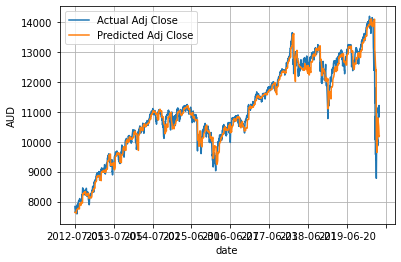

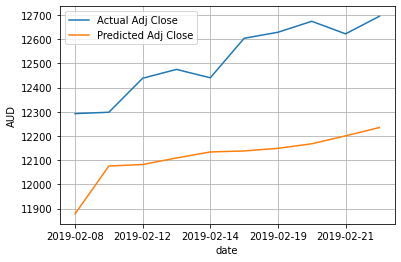

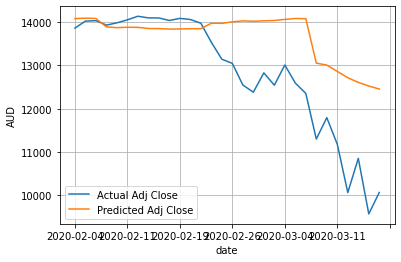

In [74]:
test = dataset[train_cut - lags:][include]
test_adj = test[features]
predict(test_adj, forecasts, lags, test['Date'])

(972, 100, 12)
(1082, 12)
MAPE: 1.823425320848781


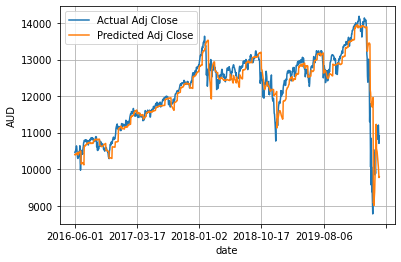

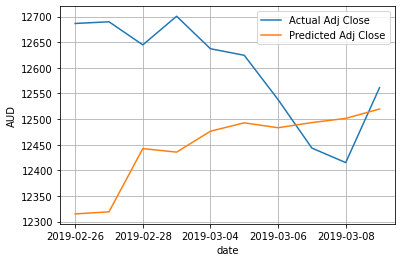

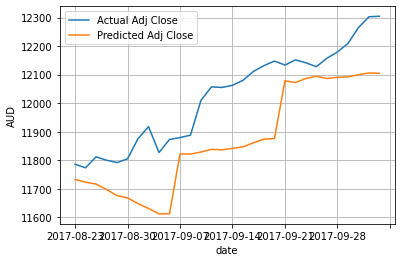

In [75]:
final_test = dataset[val_cut - lags:][include]
final_test_adj = final_test[features]
predict(final_test_adj, forecasts, lags, final_test['Date'])

In [0]:
# Saving the model so it can be used in our web app
model.save('/content/model_10.h5')
# !zip -r /content/model.zip /content/model

In [0]:
new_model = tf.keras.models.load_model('/content/model')

In [0]:
new_model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 200, 250)          263000    
_________________________________________________________________
lstm_7 (LSTM)                (None, 200, 100)          140400    
_________________________________________________________________
lstm_8 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_115 (Dense)            (None, 128)               12928     
_________________________________________________________________
dense_116 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_117 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_118 (Dense)            (None, 64)              